written by Yodai Takei (ytakei@caltech.edu), Feburary 2022

In [2]:
# Our numerical workhorses
import numpy as np
import pandas as pd
import re
from collections import defaultdict, Counter
import math
import scipy.optimize
import os
import glob

# Plotting modules
import matplotlib.pyplot as plt
import matplotlib.patches

# Package to perform PCA
import sklearn.datasets
import sklearn.decomposition

# This is to enable inline displays for the purposes of the tutorial
%matplotlib inline

# This enables SVG graphics inline
%config InlineBackend.figure_formats = {'png', 'retina'}

# Seaborn makes plots look nice
import seaborn as sns


rc = {'lines.linewidth': 2, 'axes.labelsize': 18,  'axes.titlesize': 18, 'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style('ticks')

# Suppress future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
data_path_2 = "I:/OneDrive - California Institute of Technology/Long Cai - 1/100k/LC1-100k-000-reference-analysis/output/"
file_name_2 = "LC1-100k-000-006-mouse-whole-genome-25kb-blocks-annotated.csv"
df_ref = pd.read_csv(data_path_2+file_name_2)
df_ref = df_ref[['name','chrom','start','end','compartment']]
df_ref.head()

,name,chrom,start,end,compartment
0,chr1-1,chr1,3000000,3025000,B
1,chr1-2,chr1,3025000,3050000,B
2,chr1-3,chr1,3050000,3075000,B
3,chr1-4,chr1,3075000,3100000,B
4,chr1-5,chr1,3100000,3125000,B


In [6]:
chrom_list = list(df_ref['chrom'].unique())
chrom_list

['chr1',
 'chr2',
 'chr3',
 'chr4',
 'chr5',
 'chr6',
 'chr7',
 'chr8',
 'chr9',
 'chr10',
 'chr11',
 'chr12',
 'chr13',
 'chr14',
 'chr15',
 'chr16',
 'chr17',
 'chr18',
 'chr19',
 'chrX']

In [402]:
def hull_intersection(points,hull):
    p_eq = hull.equations
    normal, dist = p_eq[:,:-1],p_eq[:,-1]
    alpha = -dist/np.dot(normal,points.T)
    return np.multiply(np.min(alpha[alpha>0]),points)

In [60]:
def surf_scdist(df_f,col1='n_rad_score',col2='n_per_dist(um)'):
    # output both normalized radial score (from 0 to 1) and absolute physical distance (um) from periphery
    # only used physical distance in the publication.
    
    df_f1 = df_f.copy(deep=True)
    
    df_f1['x_um'] = df_f1['x_um'] - df_f1['x_um'].mean()
    df_f1['y_um'] = df_f1['y_um'] - df_f1['y_um'].mean()
    df_f1['z_um'] = df_f1['z_um'] - df_f1['z_um'].mean()
    
    x = df_f1['x_um']
    y = df_f1['y_um']
    z = df_f1['z_um']
    
    points = np.array(df_f1[['x_um','y_um','z_um']])
    hull = scipy.spatial.ConvexHull(points)
    
    closest_point = []
    for i in range(len(df_f1)):
        closest_point.append(list(hull_intersection(points[i],hull)))
        
    df_cp = pd.DataFrame(closest_point)

    x1 = df_cp[0]
    y1 = df_cp[1]
    z1 = df_cp[2]

    sqrt1 = np.array(np.sqrt(x**2 + y**2 + z**2))
    sqrt2 = np.array(np.sqrt(x1**2 + y1**2 + z1**2))

    # normalized radial score from center
    norm = sqrt1/sqrt2 

    # absolute distance from lamin or nuclear periphery
    # in this case, this is identical to np.array(np.sqrt((x-x1)**2 + (y-y1)**2 + (z-z1)**2))
    lamin_um = sqrt2 - sqrt1  

    df_norm = pd.DataFrame([norm,lamin_um]).transpose()
    
    df_norm.columns = [col1,col2]
    
    return df_norm

In [238]:
path = 'I:/OneDrive - California Institute of Technology/hpc-data/2022-02-09-updated-results/'

max_p = [11,12]

for r in range(2):
    for i in range(max_p[r]):
        # input file is DNA spots after DBSCAN/LDP homologous chromosome separation.
        max_dcd = pd.read_csv(path+'E14_rep'+str(r+2)+'_replicate'+str(r+1)+'_pos_'+str(i)+'.csv')
        max_dcd = max_dcd[max_dcd['dbscan_ldp_nbr_allele']!=-1].reset_index(drop=True)
        max_dcd['x_um'] = max_dcd['x']*0.103 # convert to physical distance (um)
        max_dcd['y_um'] = max_dcd['y']*0.103 # convert to physical distance (um)
        max_dcd['z_um'] = max_dcd['z']*0.250 # convert to physical distance (um)
        
        df_nr = []
        for j in range(max_dcd['cellID'].max()):
            print(r+1, i, j+1)
            df_f2 = max_dcd[max_dcd['cellID']==j+1].reset_index(drop=True)
            # compute radial scores from nuclear center as well as distance (um) from nuclear periphery
            df_norm = surf_scdist(df_f2,col1='n_rad_score',col2='n_per_dist(um)')
            df_f2 = pd.concat([df_f2,df_norm],axis=1)
            
            df_ca = pd.DataFrame(df_f2.groupby(['chrom','dbscan_ldp_nbr_allele']).size()).reset_index()
            
            for ca in range(len(df_ca)):
                if df_ca[0][ca] > 0: # consider homologous chromosomes with >0 (cell culture) >100 dots (brain)
                    df_c1 = df_f2[(df_f2['chrom']==df_ca.chrom[ca])&\
                                  (df_f2['dbscan_ldp_nbr_allele']==df_ca.dbscan_ldp_nbr_allele[ca])].reset_index(drop=True)
                    # compute radial scores from chromosome center as well as distance (um) from chromosome surface
                    df_n1 = surf_scdist(df_c1,col1='c_rad_score',col2='c_surf_dist(um)')
                    df_nrc = pd.concat([df_c1,df_n1],axis=1)
    
                    if len(df_nr) == 0:
                        df_nr = df_nrc.copy(deep=True)
                    else:
                        df_nr = pd.concat([df_nr,df_nrc],axis=0).reset_index(drop=True) 
                
        df_nr.to_csv('output/E14_rep'+str(r+2)+'_replicate'+str(r+1)+'_pos_'+str(i)+'_radial_scores_wofilter.csv')

1 0 1
1 0 2
1 0 3
1 0 4
1 0 5
1 0 6
1 0 7
1 0 8
1 0 9
1 0 10
1 0 11
1 0 12
1 0 13
1 0 14
1 0 15
1 0 16
1 0 17
1 0 18
1 0 19
1 0 20
1 0 21
1 0 22
1 0 23
1 0 24
1 0 25
1 0 26
1 0 27
1 0 28
1 0 29
1 0 30
1 0 31
1 0 32
1 0 33
1 0 34
1 0 35
1 0 36
1 0 37
1 0 38
1 0 39
1 0 40
1 0 41
1 0 42
1 0 43
1 0 44
1 0 45
1 0 46
1 0 47
1 0 48
1 0 49
1 0 50
1 0 51
1 0 52
1 0 53
1 0 54
1 0 55
1 0 56
1 0 57
1 0 58
1 0 59
1 1 1
1 1 2
1 1 3
1 1 4
1 1 5
1 1 6
1 1 7
1 1 8
1 1 9
1 1 10
1 1 11
1 1 12
1 1 13
1 1 14
1 1 15
1 1 16
1 1 17
1 1 18
1 1 19
1 1 20
1 1 21
1 1 22
1 1 23
1 1 24
1 1 25
1 1 26
1 1 27
1 1 28
1 1 29
1 1 30
1 1 31
1 1 32
1 1 33
1 1 34
1 1 35
1 1 36
1 1 37
1 1 38
1 1 39
1 1 40
1 1 41
1 1 42
1 1 43
1 1 44
1 1 45
1 1 46
1 1 47
1 1 48
1 1 49
1 1 50
1 2 1
1 2 2
1 2 3
1 2 4
1 2 5
1 2 6
1 2 7
1 2 8
1 2 9
1 2 10
1 2 11
1 2 12
1 2 13
1 2 14
1 2 15
1 2 16
1 2 17
1 2 18
1 2 19
1 2 20
1 2 21
1 2 22
1 2 23
1 2 24
1 2 25
1 2 26
1 2 27
1 2 28
1 2 29
1 2 30
1 2 31
1 2 32
1 2 33
1 2 34
1 2 35
1 2 36
1 2 37
1 2 3

example nuclear radial score in the center section of the nucleus

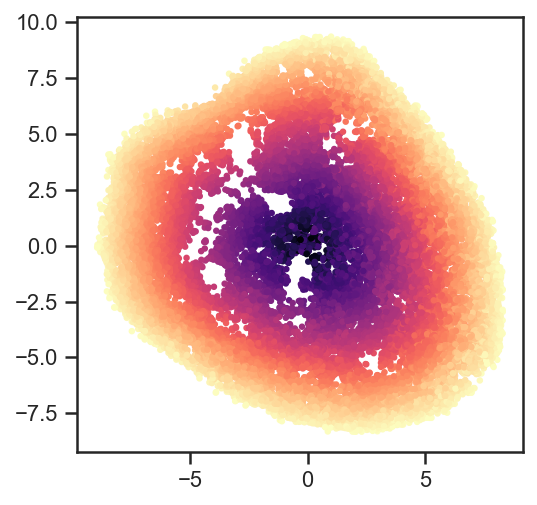

In [239]:
fig, ax = plt.subplots(1,1, figsize=(4,4))

df_f2 = df_nr[df_nr['cellID']==2].reset_index(drop=True)
df_f2['x_um'] = df_f2['x']*0.103 - np.mean(df_f2['x']*0.103)
df_f2['y_um'] = df_f2['y']*0.103 - np.mean(df_f2['y']*0.103)
df_f2['z_um'] = df_f2['z']*0.250 - np.mean(df_f2['z']*0.250)

plt.scatter(df_f2[(df_f2['z_um']>-0.5)&(df_f2['z_um']<0.5)]['x_um'],
         -df_f2[(df_f2['z_um']>-0.5)&(df_f2['z_um']<0.5)]['y_um'],s=5, 
         c=df_f2[(df_f2['z_um']>-0.5)&(df_f2['z_um']<0.5)]['n_rad_score'],cmap='magma')

example chromosome radial score (Chr7 homologous chromosome 1) in the nucleus

Text(0, 0.5, 'y (um)')

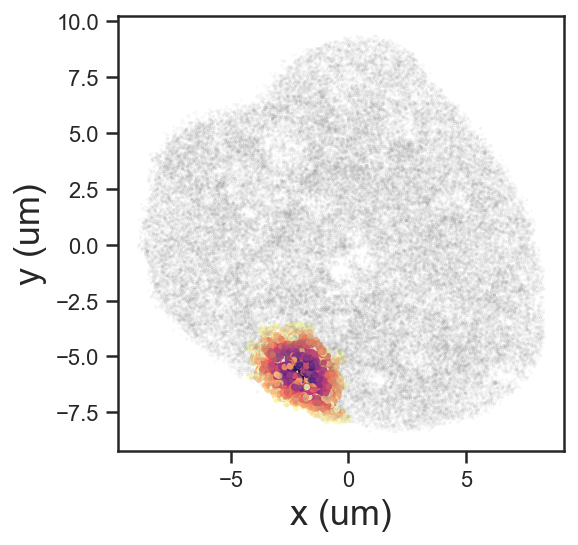

In [240]:
fig, ax = plt.subplots(1,1, figsize=(4,4))

plt.plot(df_f2['x_um'],-df_f2['y_um'],'.',ms=0.5,color='grey',alpha=0.1)

plt.scatter(df_f2[(df_f2['chrom']=='chr7')&(df_f2['dbscan_ldp_nbr_allele']==1)]['x_um'],
            -df_f2[(df_f2['chrom']=='chr7')&(df_f2['dbscan_ldp_nbr_allele']==1)]['y_um'],s=5, 
            c=df_f2[(df_f2['chrom']=='chr7')&(df_f2['dbscan_ldp_nbr_allele']==1)]['c_rad_score'],cmap='magma')

plt.xlabel('x (um)')
plt.ylabel('y (um)')